#**Essay of Cognition and Computation**
by Roberto Russo - roberto.russo.4@studenti.unipd.it

The aim of this essay is to test the capacity of the Deep Beliefe Network architetecture to learn an human-like visual rapresentation of the images of the CIFAR10 dataset which contains ten classes of images. In order to do this, three main things will be evaluated: the internal features learned by the model, the nearness of the classes within the rapresentation of the model, and the accuracy of the classification using the features learned by the DBN.

The content of this notebook is divided as follows:

1.   Importing the libraries that are used in the notebook;
2.   Importing the dataset;
3.   Training the DBN to reconstruct the inputs
4.   Visualization of the features that the DBN has learnt;
5.   Clustering the feature according to the labels
6.   Training a linear read-out in top of the DBN and evaluate the perfomance
7.   Testing the linear read-out with noisy images.



###1. Importing the libraries
For this essay I am using the code from the laboratories, with the proper modifications.

In [ ]:
def _get_files_from_repo(files, repo):
  repository_url = f"https://raw.githubusercontent.com/flavio2018/{repo}/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
files = ["RBM.py"]
_get_files_from_repo(files, "Deep-Belief-Network-pytorch")

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as functional
import torch.nn.functional as F
from RBM import RBM
from torch.autograd import Variable
import torchvision as tv
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import tqdm
import pandas as pd
#from DBN import DBN
import numpy as np
from torchvision.utils import make_grid
import math
import scipy.cluster as cluster

Here there is the code for the DBN class. I have modified it in order to work with colored images with shape  $ n * n * 3 $.


In [ ]:

class DBN(nn.Module):
    """Class implementing a DBN using the basic RBM class."""
    def __init__(self,
                 visible_units=256,
                 hidden_units=[64, 100],
                 k=2,
                 learning_rate=1e-5,
                 learning_rate_decay=False,
                 weight_decay=.0002,
                 initial_momentum=.5,
                 final_momentum=.9,
                 xavier_init=False,
                 increase_to_cd_k=False,
                 use_gpu=False):
        super(DBN, self).__init__()

        self.n_layers = len(hidden_units)
        self.rbm_layers = []
        self.rbm_nodes = []

        # Creating different RBM layers
        for i in range(self.n_layers):
            input_size = 0
            if i == 0:
                input_size = visible_units
            else:
                input_size = hidden_units[i - 1]
            rbm = RBM(visible_units=input_size,
                      hidden_units=hidden_units[i],
                      k=k,
                      learning_rate=learning_rate,
                      learning_rate_decay=learning_rate_decay,
                      weight_decay=weight_decay,
                      initial_momentum=initial_momentum,
                      final_momentum=final_momentum,
                      xavier_init=xavier_init,
                      increase_to_cd_k=increase_to_cd_k,
                      use_gpu=use_gpu)

            self.rbm_layers.append(rbm)

        # rbm_layers = [RBM(rbn_nodes[i-1] , rbm_nodes[i],use_gpu=use_cuda) for i in range(1,len(rbm_nodes))]
        self.W_rec = [
            nn.Parameter(self.rbm_layers[i].W.data.clone())
            for i in range(self.n_layers - 1)
        ]
        self.W_gen = [
            nn.Parameter(self.rbm_layers[i].W.data)
            for i in range(self.n_layers - 1)
        ]
        self.bias_rec = [
            nn.Parameter(self.rbm_layers[i].h_bias.data.clone())
            for i in range(self.n_layers - 1)
        ]
        self.bias_gen = [
            nn.Parameter(self.rbm_layers[i].v_bias.data)
            for i in range(self.n_layers - 1)
        ]
        self.W_mem = nn.Parameter(self.rbm_layers[-1].W.data)
        self.v_bias_mem = nn.Parameter(self.rbm_layers[-1].v_bias.data)
        self.h_bias_mem = nn.Parameter(self.rbm_layers[-1].h_bias.data)

        for i in range(self.n_layers - 1):
            self.register_parameter('W_rec%i' % i, self.W_rec[i])
            self.register_parameter('W_gen%i' % i, self.W_gen[i])
            self.register_parameter('bias_rec%i' % i, self.bias_rec[i])
            self.register_parameter('bias_gen%i' % i, self.bias_gen[i])

    def forward(self, input_data):
        """running the forward pass
        do not confuse with training this just runs a forward pass

        :param input_data:
        """
        v = input_data
        for i in range(len(self.rbm_layers)):
            v = v.reshape((v.shape[0], -1)).type(torch.FloatTensor)  # flatten
            p_v, v = self.rbm_layers[i].to_hidden(v)
        return p_v, v

    def reconstruct(self, input_data):
        """go till the final layer and then reconstruct

        :param input_data:
        """
        h = input_data
        p_h = 0
        for i in range(len(self.rbm_layers)):
            h = h.reshape((h.shape[0], -1)).type(torch.FloatTensor)  # flatten
            p_h, h = self.rbm_layers[i].to_hidden(h)

        v = h
        for i in range(len(self.rbm_layers) - 1, -1, -1):
            v = v.reshape((v.shape[0], -1)).type(torch.FloatTensor)
            p_v, v = self.rbm_layers[i].to_visible(v)
        return p_v, v

    def train_static(self,
                     train_data,
                     train_labels,
                     num_epochs=50,
                     batch_size=10):
        """Greedy Layer By Layer training
        Keeping previous layers as static

        :param train_data: 
        :param train_labels: 
        :param num_epochs:  (Default value = 50)
        :param batch_size:  (Default value = 10)
        """
        tmp = train_data

        for i in range(len(self.rbm_layers)):
            print("-" * 20)
            print("Training RBM layer {}".format(i + 1))

            # transform to torch tensors
            tensor_x = tmp.type(torch.FloatTensor)
            tensor_y = train_labels.type(torch.FloatTensor)
            _dataset = torch.utils.data.TensorDataset(
                tensor_x, tensor_y)  # create your dataset
            _dataloader = torch.utils.data.DataLoader(
                _dataset, batch_size=batch_size,
                drop_last=True)  # create your DataLoader

            self.rbm_layers[i].train(_dataloader, num_epochs, batch_size)
            # print(train_data.shape)
            v = tmp.reshape((tmp.shape[0], -1)).type(torch.FloatTensor)  # flatten
            if self.rbm_layers[i].use_gpu:
                v = v.cuda()
            p_v, v = self.rbm_layers[i].forward(v)
            tmp = p_v
            # print(v.shape)
        return

    def train_ith(self, train_data, train_labels, num_epochs, batch_size,
                  ith_layer):
        """taking ith layer at once
        can be used for fine tuning

        :param train_data: 
        :param train_labels: 
        :param num_epochs: 
        :param batch_size: 
        :param ith_layer:
        """
        if (ith_layer - 1 > len(self.rbm_layers) or ith_layer <= 0):
            print("Layer index out of range")
            return
        ith_layer = ith_layer - 1
        v = train_data.view((train_data.shape[0], -1)).type(torch.FloatTensor)

        for ith in range(ith_layer):
            p_v, v = self.rbm_layers[ith].forward(v)

        tmp = v
        tensor_x = tmp.type(torch.FloatTensor)  # transform to torch tensors
        tensor_y = train_labels.type(torch.FloatTensor)
        _dataset = torch.utils.data.TensorDataset(
            tensor_x, tensor_y)  # create your datset
        _dataloader = torch.utils.data.DataLoader(_dataset,
                                                  batch_size=batch_size,
                                                  drop_last=True)
        self.rbm_layers[ith_layer].train(_dataloader, num_epochs, batch_size)
        return




##2. Importing the dataset
The dataset is the CIFAR10. It is composed of 60000 of images and has 10 classes (and so labels) of images listed below:


1.   Airplane;
2.   Automobile;
3.   Bird;
4.   Cat;
5.   Deer;
6.   Dog
7.   Horse;
8.   Frog;
9.   Ship
10.  Truck.

For each class there are 5000 images in the training set and 1000 on the test set. Every image has shape $ 32 * 32 $ and has three channels since it is in RGB scale. So the final shape of every image is $ 32 * 32 * 3 $.

As humans, we tend to think that a cat is visually more similar to a dog than similar to a truck. That makes sense because in the first case we are comparing two animals and in the second we are not. But even if we consider the similarity between a cat and a frog we find that a dog is much more similar to the cat, at least visually. This also makes sense because as humans we have learned that the dog and the cat belong to the same category of animals, i.e. they are both mammals, while the frog is not. But even picking another animal from the mammals, like the horse, it is safe to say that the horse does not look like a cat as much as the dog does. The difference here it's mainly due to the feet: dogs and cats have paws while horses have hooves, also the shape of the horse's head it's quite different from both the shape of the head of a cat and dog, while a dog's head and cat's head have more features in common.

As humans we have learned to distinguish between objects at different levels: 


1.  Sensory levels: a cat differs from a dog visually, both of them have different voices and make different sounds or two food have different tastes, and so on;
2.  according to what we perceive from our senses, we build categories and sub-categories, where the more categories a sub_category is contained in, the less object it contains and the more those objects are similar to each other. For example, we have the category of living entities, that contains the category of animals, that contains the category of mammals, that contains the category of cats, that contains several categories according to each race of cat. To belong to a particular category, an entity must have particular characteristics: for example, there is no dog that has wings, or that is made out of steel or that is born from an egg. Each sub-category inherits all the characteristics of the categories that contain it. For example, all birds have wings, the eagle is a bird and so must have wings. 

As humans, we use all these features to classify the objects that we perceive from the world, some of them are visual (or anyway sensorial) features, some others are more abstracts and complexes, like the fact that a dog does not come to the existence by mean of an egg. We know that because we have never seen a dog coming out from an egg, and we have learned that reproducing using egg is not a characteristic of the mammals, and since the dog is a mammal then dogs cannot be born from eggs. So we have learned the same feature at different levels, but to discover this feature it was necessary to observe the birth of a dog to us know how dogs come to life, and so we were not just observing a dog, but a dog that was committing a particular action. Hence this is not a feature that we can learn just by looking at a dog. For this essay visual features are to be intended as the features you can discover about an object just by looking at it when it is not doing any particular action, or anyway, all those features that we can observe with our eyes that are action-independent. Those features can be for example the typical face of a dog, the typical shape of a car. An important observation to do is that a class of objects can contain objects that are visually very different from each other, for example, imagine the mop dog and the pitbull, they are both dogs but they are so different that maybe a child, just looking at them, could say that they are not both dog. Visually speaking they share few features, like the paws, the nose, the teeth, and the shape of a quadruped, and a child probably needs to hear them bark and see them doing "dogs' " stuff to understand that they are both dogs. So when we want to compare any model trained on images with the visual human performance, we should take into consideration that a human has learned visual feature in correlation with non-visual features, so somehow our visual representation store some non-visual information that allows us to know that the visual features of a dog have huge variability. While any machine learning model sees a mop dog and it is told that it is a dog, then it sees a pitbull it is told that is a dog, and the model has to figure out that a dog can look like a mop dog or a pitbull, and it should identify what are the relevant visual features that every dog has. The same holds for the cars, think that a Ferrari Daytona and a Fiat Panda are both cars. In this case, we can say that the common visual features are the four tires that have a particular position with respect to each other and the car itself, the windscreen, and the windows. Another point is that as humans we can observe objects from different perspectives, having the consciousness of the changing of perspective, and we build a 3-D representation of the objects. Hence when we observe a car from the side, and we see just two tires and maybe we cannot see the windscreen, we still know it is a car, because from the two tires we can infer that on the other side there are other two tires as well as the windows, and basically we know that a car has a symmetrical shape. While a ML model trained on images sees objects from the same class from different perspectives (that results in seeing the same class of objects with different shapes) and has to learn that they are the same thing, in other words, it has to learn somehow the concept of perspective, even if related to the specific class of object that it is trained on. The ML trained on images is required to learn a 3-D representation of the object observing 2-D data and with no consciousness of the change of perspective. Last but not least, humans have the innate ability to learn useful features in one shot, for example, when observing an unseen species of animal, if it has a face we instantly recognize it as well as the eyes, the mouth, the ears, the feet, while in principle, for a ML model the eyes do not matter more than every other part of the image. This is because for the ML model every part of the picture is just a bunch of pixels. So having clear in mind that a human has a clear advantage over any machine learning model at building visual representation$^1$, if we want to build an intelligent system that perfectly resembles the way of thinking of a human, we should build a model that put in correlation features from different level of perception and with different level of abstraction and complexity. 
 

Having said that, the focus of this essay is to evaluate the human-likeliness of the DBN architecture at visual level perception: the ability to extrapolate visual features as a human would do just by looking at the images of the CIFAR10, for example, learning the prototype of a face of a dog, or the typical shape of a ship; the nearness of the objects inside the representation; and at the end, the ability to correctly classify object using the representation learned from the DBN.


$^1$At least for what concerns the use of the visual representation that a human would do. If we think that a human cannot extrapolate any information from a QR-code or a bar code, while a machine can easily do it, we can see that the advantage that humans have over machines is not absolute, and we can also appreciate the fact that the No free lunch theorem holds also for the "learning algorithm" of our brain.

In [ ]:
%%capture
dataset_train = tv.datasets.CIFAR10('data/', train=True, transform = tv.transforms.Compose(
                                                  [tv.transforms.ToTensor(), tv.transforms.Grayscale()]), download=True)
dataset_test = tv.datasets.CIFAR10('data/', train=False, transform = tv.transforms.Compose(
                                                  [tv.transforms.ToTensor(), tv.transforms.Grayscale()]), download=True)


In [ ]:
print('Size of training dataset :', len(dataset_train))

Size of training dataset : 50000


In [ ]:
img, label = dataset_train[1]
print(img.shape)

torch.Size([1, 32, 32])


This is a : truck


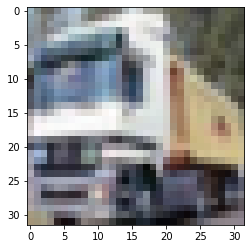

In [ ]:
idx = 1
print("This is a : {}".format(dataset_train.classes[dataset_train[idx][1]]) )
plt.imshow(dataset_train.data[idx, :, :, :])
plt.show()

In [ ]:
dataset_train.data.shape

(50000, 32, 32, 3)

Getting the data set in the proper type

In [ ]:
data_train = torch.tensor(dataset_train.data)#[:, :, :, 1])
targets_train = torch.tensor(dataset_train.targets)

data_test = torch.tensor(dataset_test.data)#[:, :, :, 1])
targets_test = torch.tensor(dataset_test.targets)

Scaling the data set

In [ ]:
data_train = (data_train.type(torch.FloatTensor)/255)
data_test = (data_test.type(torch.FloatTensor)/255)

In [ ]:
data_train.shape

torch.Size([50000, 32, 32, 3])

## 3. The DBN Architecture
It is a stochastic recurrent network architecture where every visible unit is linked only with all the hidden units of the first layer (they are the Markov blanket of that visible unit), then every unit of the first hidden layers is linked with all the hidden units of the second layer, and so on. A simple DBN with just one hidden layer is called Restricted Boltzmann Machine. It is called Restricted because every unit is linked just with all the units of the next/previous layer. Every unit activation of the hidden layer represents a probability with the following distribution:


$P(x_i=1)=\frac{1}{1 + e^{-\frac{1}{T}} \sum_{i=1}^n w_{ij} x_j}$


The link is undirected so the information flows in both directions with the contrastive divergence algorithm. The idea of the algorithm is to minimize the discrepancy between the empirical data distribution (training set) and the model distribution. The idea of the algorithm resembles the way humans build their representation of the perceived world: we perceive the external world, we infer a particular structure of the events and the objects, and then we use this structure to perform tasks, and we eventually adjust this structure if we see that the representation that we had of something led us to mistake. Every epoch is formed by two phases: the positive phase and the negative phase. In the positive phase, we feed the input (visible units) to the hidden units, activate the units, and compute the correlation between all visible and hidden neurons $<v^{+}h^{+}>$. In the negative phase, we compute the activation function values and we use them as they were the visible units, so we feed those values to the hidden units and compute the correlation between those values and the visible units $<v^{-}h^{-}>$. The weights are updated as follows: 
$ w_{t+1} = w_t + lr*(<v^{+}h^{+}> - <v^{-}h^{-}>)$.
Also, the positive and the negative phases recall the way we learn (at least at an abstract level), because usually we first observe (study) the environment, then we see if the idea that we have about something is coherent with what that thing actually is. As an example, we first study Cognition and Computation, then we write an essay and see if what we have learned is consistent with what the professors taught us.
Training a RBM (or a DBN) is equivalent to burning a Markov chain. Depending on how many iterations we train or network we may reach the stationary distribution of this Markov chain, but usually we can stop earlier with good results in terms of reconstruction. For this essay, I use 6 hidden layers in order to explore and analyze the representation on different layers. Each layer has n units. The other hyperparameters control the optimization procedure, but for the aim of this essay, it is sufficient to explore the representation at different layers.

In [ ]:
dbn_cifar100 = DBN(visible_units=3*32*32,
                hidden_units=[2000, 2000, 2000, 2000 , 2000, 2000],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.9,
                weight_decay=0.00002,
                xavier_init=True,
                increase_to_cd_k=False,
                use_gpu=True)

I train each layer for 50 epochs, with a batch_size of 100. 50 epochs are enough because for some layers, the average reconstruction error slightly increase after it decreased, and after the 40th epoch we can obseerve a substantial decrease in the average reconstruction error when we move to the next layer. The procedure is the following: I first train the DBN on the train set, the I evaluate the representation on of the model, the I train a linear read-out on top of the trained DBN using the train set, and evaluate the performance on the test set. Increasing the number of unit per layer allows a decreasing of reconstruction error when training the layers. 2000 units for each layer allows a fast training with a better performance, increasing over that would cost too much time for training, but would also increase the perfomance. 

In [ ]:
num_epochs = 50
batch_size = 100

dbn_cifar100.train_static(
    data_train,
    targets_train,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |2.4552   |0.1212   |1158.3569 |51.2739   |
|20    |2.3496   |0.1074   |1224.0148 |55.3409   |
|30    |2.3207   |0.1093   |1160.0632 |55.0908   |
|40    |2.3292   |0.1022   |1179.5736 |51.5317   |
|50    |2.3219   |0.1050   |1117.9711 |49.5313   |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.0871   |0.0067   |125.0707 |8.7008   |
|20    |0.0769   |0.0051   |115.2137 |6.9719   |
|30    |0.0733   |0.0047   |113.0927 |6.7164   |
|40    |0.0717   |0.0044   |112.9337 |6.7425   |
|50    |0.0704   |0.0042   |113.0423 |6.6467   |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.0842   |0.0051   |99.2011 |4.1017   |
|20    |0.0746   |0.0047   |95.1922 |4.4967   |
|30    |0.0741   |0.0047   |94.9996 |3.9216   |
|40    |0.0744   |0.0048   |96.4968 |3.6946   |
|50    |

We can observe from the table above, that after the first layer the perfomance increase a lot, but after the second layer the increase is 2 order of magnitude lower, so we can expect that the representation didn't improve much after that.

##4.   Visualization of the features that the DBN has learnt

In [ ]:
#code for showing 
def _move_parameters_to_cpu(dbn_cifar100):
  for layer in dbn_cifar100.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()

In [ ]:
#code for showing 
def _apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)
  
def _plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((32,32, 3)), cmap=plt.cm.gray)  # here we select the weights we want to plot

In [ ]:
_move_parameters_to_cpu(dbn_cifar100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

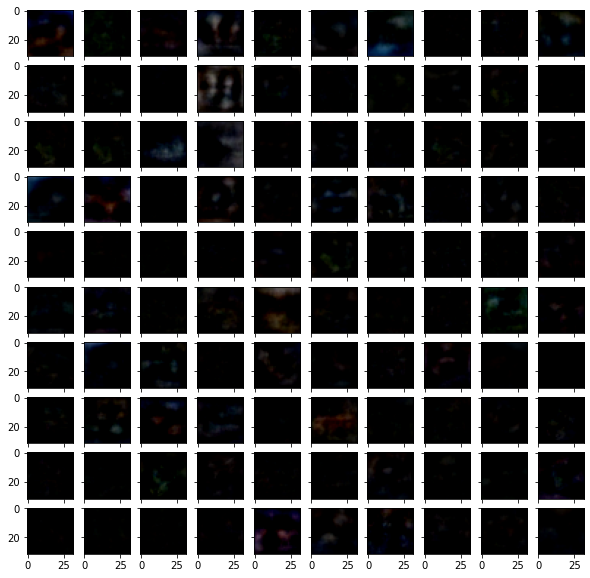

In [ ]:
#code for showing 
learned_weights_layer_1 = dbn_cifar100.rbm_layers[0].W.transpose(0,1).numpy()
learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, 0)

_plot_layer_receptive_fields(learned_weights_layer_1)

We can observe that here the neurons respond to almost no stimolus, and this explains the bad reconstruction error.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

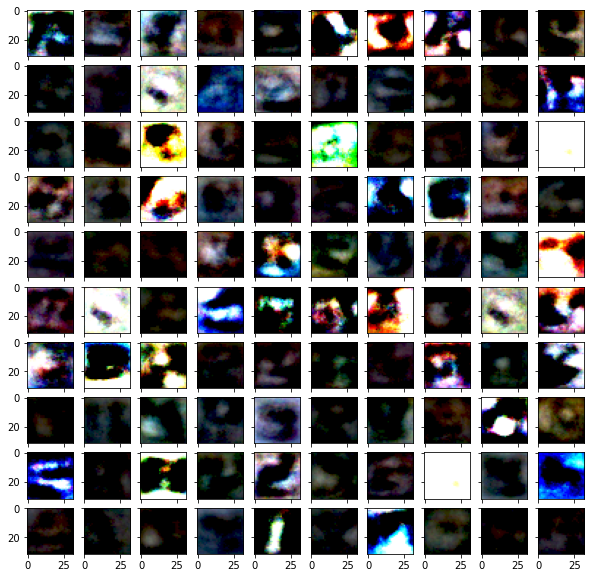

In [ ]:
#code for showing 

learned_weights_layer_1 = dbn_cifar100.rbm_layers[0].W.numpy()
learned_weights_layer_2 = dbn_cifar100.rbm_layers[1].W.numpy()

learned_weights_layer_1 = _apply_threshold(learned_weights_layer_1, .1)
learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, .1)

learned_weights_product_1 = (learned_weights_layer_1 @ learned_weights_layer_2).T  # here we do the projection
learned_weights_product_1 = _apply_threshold(learned_weights_product_1, .1)

_plot_layer_receptive_fields(learned_weights_product_1)

The neurons of the second layer respond to a variety of colors and some kind of confusing shapes. That explains the low reconstruction error, combining together all these features the DBN is able to produce images that resemble (at least at pixel level) the images passed as input during the training phase. Since after the second layer the reconstruction error didn't improve much, we expect that also the neurons didn't change much.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

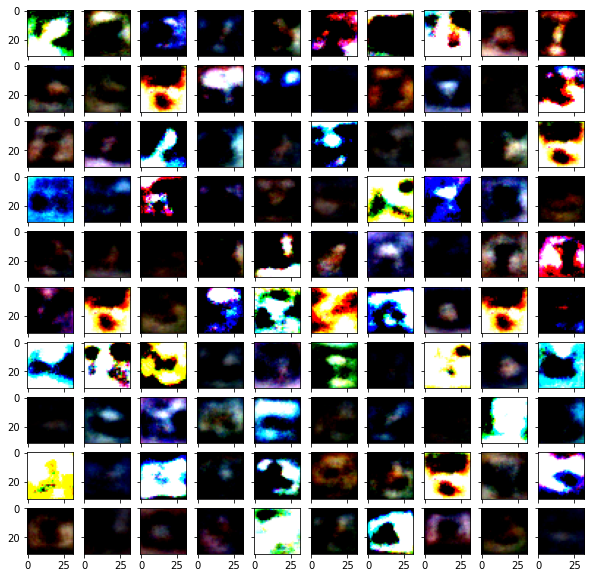

In [ ]:
#learned_weights_layer_2 = dbn_cifar100.rbm_layers[1].W.numpy()
learned_weights_layer_3 = dbn_cifar100.rbm_layers[2].W.numpy()

#learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0)
learned_weights_layer_3 = _apply_threshold(learned_weights_layer_3, .1)

learned_weights_product = (learned_weights_layer_3 @ learned_weights_product_1) # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product, 0)

_plot_layer_receptive_fields(learned_weights_product)

We can observe that the first 3 layers are triggered just by different colors, they respond to some shapes that do not make much sense for a human, but capturing the colors is not so bad, after all we have never seen a blue dog, or a purple deer.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

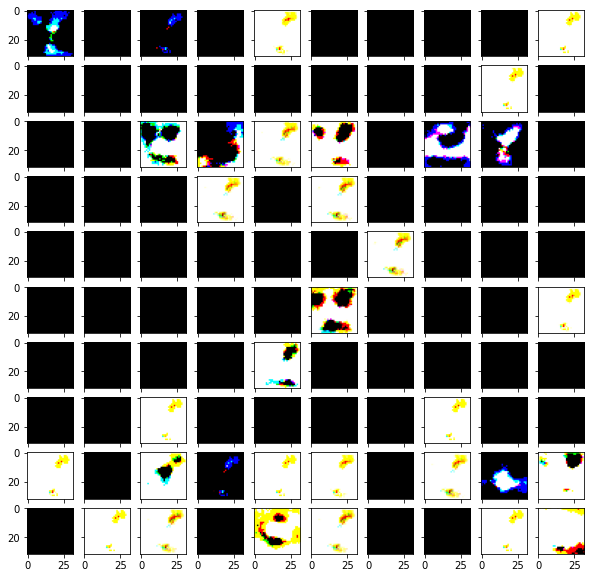

In [ ]:
#learned_weights_layer_2 = dbn_cifar100.rbm_layers[1].W.numpy()
learned_weights_layer_4 = dbn_cifar100.rbm_layers[3].W.numpy()

#learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0)
learned_weights_layer_4 = _apply_threshold(learned_weights_layer_4, 0.1)

learned_weights_product_2 = (learned_weights_layer_4 @ learned_weights_product) # here we do the projection
learned_weights_product_2 = _apply_threshold(learned_weights_product_2, 0)

_plot_layer_receptive_fields(learned_weights_product_2)

Here seems that again most of the neurons do not respond to any particular shape, but some of them respond to a very bright stimulus.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

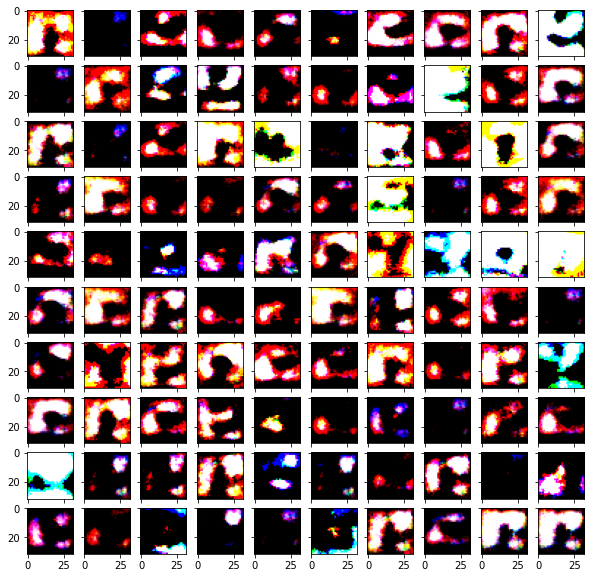

In [ ]:
#learned_weights_layer_2 = dbn_cifar100.rbm_layers[1].W.numpy()
learned_weights_layer_5 = dbn_cifar100.rbm_layers[4].W.numpy()

#learned_weigt sohts_layer_2 = _apply_threshold(learned_weights_layer_2, 0)
learned_weights_layer_5 = _apply_threshold(learned_weights_layer_5, 0.05)

learned_weights_product_3 = (learned_weights_layer_5 @ learned_weights_product_2) # here we do the projection
learned_weights_product = _apply_threshold(learned_weights_product_3, 0)

_plot_layer_receptive_fields(learned_weights_product_3)

Here the neurons respond to particular shapes that apparently do not identify any particular feature that an human would recognize.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

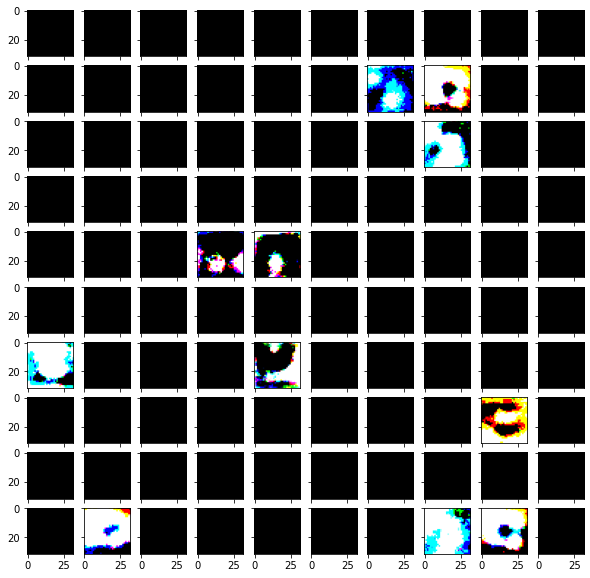

In [ ]:
learned_weights_layer_6 = dbn_cifar100.rbm_layers[5].W.numpy()

#learned_weights_layer_2 = _apply_threshold(learned_weights_layer_2, 0)
learned_weights_layer_6 = _apply_threshold(learned_weights_layer_6, 0.1)

learned_weights_product_4 = (learned_weights_layer_6 @ learned_weights_product) # here we do the projection
learned_weights_product_4 = _apply_threshold(learned_weights_product_4, 0)

_plot_layer_receptive_fields(learned_weights_product_4)

Again here most of the neurons cannot be stimulated, but some of them respond to a very singular shapes and color combination.

The conclusion about the feature learned by the DBN is that we should increase the number of neurons in order to get better features. Increasing the number of neurons would allow for each neuron to learn more specialized features. We can also observe after the fourth layer the network learned almost no new features, so one possibility is to reduce the number of neurons in the 5th and 6th layers. So a better architecture (at least in terms of feature learned) would have more neurons for each layer and the last layers with fewer neurons than the previous ones. But increasing the number of neurons would result in more time for training. Another possibility to have more humans friendly feature is to increase the number of layers, but this has to be done after the increase of the number of neruons because we can see that from the 5th layer the network does not benefit from having more layers (in terms of features learned). 

##5.   Clustering the feature according to the labels

Now I use a hyerarchical clustering algorithm to cluster the representation of each class inside the representation learned by the network.

In [ ]:
#code for clustering
def _get_kth_layer_repr(input, k):
  flattened_input = input.reshape((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_cifar100.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr

hidden_repr_layer_1 = _get_kth_layer_repr(data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)
hidden_repr_layer_4 = _get_kth_layer_repr(hidden_repr_layer_3, 3)
hidden_repr_layer_5 = _get_kth_layer_repr(hidden_repr_layer_4, 4)
hidden_repr_layer_6 = _get_kth_layer_repr(hidden_repr_layer_5, 5)

def _get_mask(label):  # we use this function to filter by class
  labels = targets_train.numpy()
  return labels == label

def _get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.numpy()
  return {
    label: hidden_representation_np[_get_mask(label)].mean(axis=0)  # here we filter by class and compute the mean
    for label in range(10)
  }

def _get_hidden_reprs_matrix(label_to_mean_hidd_repr):  # we use this to build the matrices
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)  # here we adjust the shape of centroids to do the concat
    for label in range(10)])
  
label_to_mean_hidd_repr_1 = _get_label_to_mean_hidd_repr(hidden_repr_layer_1)
label_to_mean_hidd_repr_2 = _get_label_to_mean_hidd_repr(hidden_repr_layer_2)
label_to_mean_hidd_repr_3 = _get_label_to_mean_hidd_repr(hidden_repr_layer_3)
label_to_mean_hidd_repr_4 = _get_label_to_mean_hidd_repr(hidden_repr_layer_4)
label_to_mean_hidd_repr_5 = _get_label_to_mean_hidd_repr(hidden_repr_layer_5)
label_to_mean_hidd_repr_6 = _get_label_to_mean_hidd_repr(hidden_repr_layer_6)

mean_hidd_repr_matrix_1 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_1)
mean_hidd_repr_matrix_2 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_2)
mean_hidd_repr_matrix_3 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_3)
mean_hidd_repr_matrix_4 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_4)
mean_hidd_repr_matrix_5 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_5)
mean_hidd_repr_matrix_6 = _get_hidden_reprs_matrix(label_to_mean_hidd_repr_6)

In [ ]:
def _plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage, labels = dataset_train.classes, leaf_rotation=45)
  ax.set_title(title)

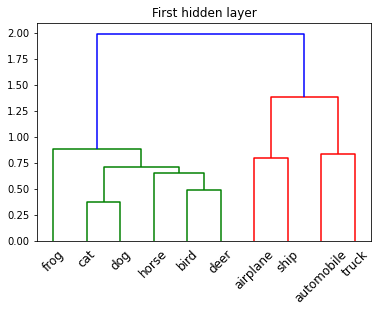

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

We can see that the first layer is able to distinguish between animals and means of transport, furthermore it recognizes similarity that as humans we would see: for example cat and dog, or automobile and truck. But the first layer is disappointing in associating bird and deer, while we would more likely associate horse and deer.

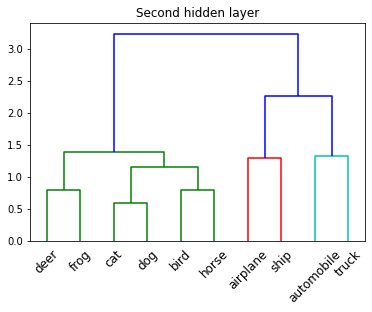

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

In the second layer the representation become worst, associating deer and frog, bird and horse, but is still human-like.

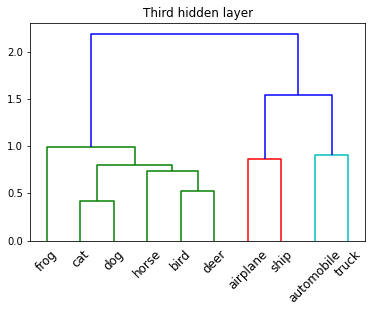

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

The third layer increases again the performance. It is euqal to the first layer with horse and deer switched, but still, the bird separates them. The frog is near to the cat, and comparing the frog with all the other animals in the dataset, the cat seems to me to be the most similar animal to a frog. The fact that the frog is very different from the other animals is captured from the fact that the frog is separated from the other animals in the early stages of the algorithm. We would expect the bird to be separated too, while is not, and the only explanation that comes to my mind for this fact is that the body's shape of a bird may resemble the head of a deer (horse )view from some particular perspective. Except for this odd association, the representation is very human-like in terms of association.

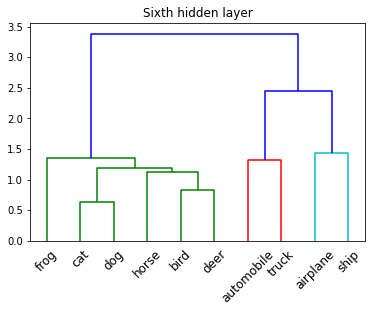

In [ ]:
_plot_dendrogram(mean_hidd_repr_matrix_6, "Sixth hidden layer")

In the sixth layer the clustering gives the same results.

##6.   Training a linear read - out in top of the DBN and evaluate the perfomance


For the linear readout, I first train the linear layer on top of the 3rd layer of the DBN and evaluate in the test set as explained before. Then I train another linear layer on top of the last layer of the DBN and evaluate it on the test set. We can observe that the network predicts almost every time frog. So the representation learned from the DBN is not good for classification.

In [ ]:
#you may need it
'''
def _move_parameters_to_cpu(dbn_mnist):
  for layer in dbn_mnist.rbm_layers:
    layer.W = layer.W.cpu()
    layer.h_bias = layer.h_bias.cpu()
    layer.v_bias = layer.v_bias.cpu()
_move_parameters_to_cpu(dbn_mnist)
'''

def _get_kth_layer_repr(input, k):
  flattened_input = input.reshape((input.shape[0], -1)).type(torch.FloatTensor)
  hidden_repr, __ = dbn_cifar100.rbm_layers[k].to_hidden(flattened_input)  # here we access the RBM object
  return hidden_repr
hidden_repr_layer_1 = _get_kth_layer_repr(data_train, 0)

In [ ]:
last_layer_size = dbn_cifar100.rbm_layers[-1].W.shape[0]

class Perceptron(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = torch.nn.Linear(last_layer_size, 10)

  def forward(self, x):
    relu = torch.nn.Sigmoid()
    
    return self.linear(x)

In [ ]:
hidden_repr_layer_1 = _get_kth_layer_repr(data_train, 0)
hidden_repr_layer_2 = _get_kth_layer_repr(hidden_repr_layer_1, 1)
hidden_repr_layer_3 = _get_kth_layer_repr(hidden_repr_layer_2, 2)
hidden_repr_layer_4 = _get_kth_layer_repr(hidden_repr_layer_3, 3)
hidden_repr_layer_5 = _get_kth_layer_repr(hidden_repr_layer_4, 4)
hidden_repr_layer_6 = _get_kth_layer_repr(hidden_repr_layer_5, 5)
#hidden_repr_layer_7 = _get_kth_layer_repr(hidden_repr_layer_6, 6)

In [ ]:
#use this one or...
def _train(network, input, epochs=1000):
  print_every_n_epochs = 100 if epochs >= 1000 else 10
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    loss = loss_fn(predictions, targets_train)
    loss.backward()
    optimizer.step()
    if epoch % print_every_n_epochs == 0:
      print("epoch {}/{}, loss = {:.6f}".format(epoch, epochs, loss))
rbm_layer_size = dbn_cifar100.rbm_layers[0].W.shape[1]
perceptron_first_hidden = Perceptron()
_train(perceptron_first_hidden, hidden_repr_layer_3, epochs=1500)

epoch 0/1500, loss = 2.303540
epoch 100/1500, loss = 2.084288
epoch 200/1500, loss = 2.000038
epoch 300/1500, loss = 1.954113
epoch 400/1500, loss = 1.924757
epoch 500/1500, loss = 1.904186
epoch 600/1500, loss = 1.888861
epoch 700/1500, loss = 1.876939
epoch 800/1500, loss = 1.867359
epoch 900/1500, loss = 1.859467
epoch 1000/1500, loss = 1.852839
epoch 1100/1500, loss = 1.847181
epoch 1200/1500, loss = 1.842287
epoch 1300/1500, loss = 1.838007
epoch 1400/1500, loss = 1.834227


In [ ]:
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import confusion_matrix

In [ ]:
def _compute_accuracy(predictions, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == targets_test).sum() / len(targets_test)
  return accuracy.item(), predictions_indices.detach().numpy()

In [ ]:
hidden_repr_layer_1_test = _get_kth_layer_repr(data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)
hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2)
hidden_repr_layer_4_test = _get_kth_layer_repr(hidden_repr_layer_3_test, 3)

In [ ]:
predictions_test = perceptron_first_hidden(hidden_repr_layer_3_test)
acc, pred = _compute_accuracy(predictions_test, targets_test)
print(acc)

0.35120001435279846


In [ ]:
conf = confusion_matrix(pred, targets_test)

In [ ]:
import seaborn as sns

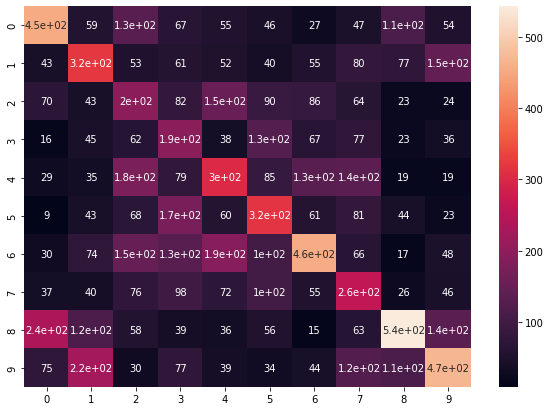

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(conf, annot=True)

As we can see, most of the error occurs by mistaking one class for the nearest one in the clustering, for example, we can observe that airplane (1) and ship (8) are mistaken plenty of times, while very few time other classes of objects are mistaken for airplane or ship. More confusion there is in the square of the animals, from 2 to 7. This indicates that while the representation distinguishes very well between animals and vehicles, it doesn't perform very well within these two macro-classes, mistaking frequently also objects that are far from each other within the representation clustering like frog and deer.

In [ ]:
rbm_layer_size = dbn_cifar100.rbm_layers[0].W.shape[1]
perceptron_first_hidden = Perceptron()
_train(perceptron_first_hidden, hidden_repr_layer_6, epochs=1500)

epoch 0/1500, loss = 2.307925
epoch 100/1500, loss = 1.982484
epoch 200/1500, loss = 1.912871
epoch 300/1500, loss = 1.879104
epoch 400/1500, loss = 1.858173
epoch 500/1500, loss = 1.843562
epoch 600/1500, loss = 1.832598
epoch 700/1500, loss = 1.823950
epoch 800/1500, loss = 1.816875
epoch 900/1500, loss = 1.810923
epoch 1000/1500, loss = 1.805809
epoch 1100/1500, loss = 1.801339
epoch 1200/1500, loss = 1.797377
epoch 1300/1500, loss = 1.793823
epoch 1400/1500, loss = 1.790607


In [ ]:
hidden_repr_layer_1_test = _get_kth_layer_repr(data_test, 0)
hidden_repr_layer_2_test = _get_kth_layer_repr(hidden_repr_layer_1_test, 1)
hidden_repr_layer_3_test = _get_kth_layer_repr(hidden_repr_layer_2_test, 2)
hidden_repr_layer_4_test = _get_kth_layer_repr(hidden_repr_layer_3_test, 3)
hidden_repr_layer_5_test = _get_kth_layer_repr(hidden_repr_layer_4_test, 4)
hidden_repr_layer_6_test = _get_kth_layer_repr(hidden_repr_layer_5_test, 5)



In [ ]:

predictions_test = perceptron_first_hidden(hidden_repr_layer_6_test)
acc, pred = _compute_accuracy(predictions_test, targets_test)
print(acc)

0.35899999737739563


In [ ]:
conf = confusion_matrix(pred, targets_test)

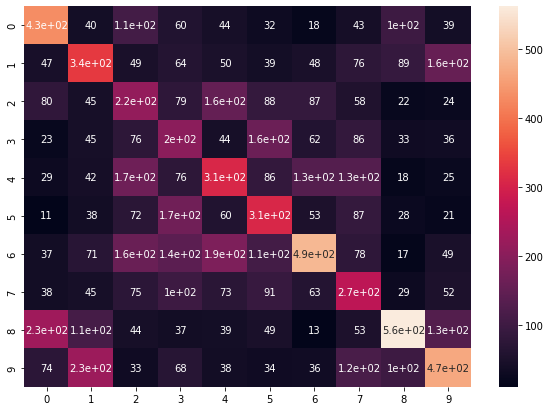

In [ ]:
plt.figure(figsize = (10,7))
sns.heatmap(conf, annot=True)

At the sixth layer the perfomance stays the same.

The conclusion about the classification remains the same as the one for the features: In order to get better performance, the number of neurons should be increased. The model can also benefit from some data augmentation. After all the top performance models for image recognition are very deep models with billions of neurons and trained on billions of images with also higher quality than the images of the CIFAR10, where some images I struggle myself to recognize what they are.

## 7.   Testing the linear read-out with noisy images


Now I want to test the robustness of the DBN in the classification when noisy images are passed in input. 

Here we inject the noise in the images of the test set.

In [ ]:
def _inject_noise(mnist_data, noise_level):
  random_gaussian_tensor = torch.randn(mnist_data.shape)/6.6 + .6
  probability_tensor = torch.ones(mnist_data.shape)*noise_level
  mask_tensor = torch.bernoulli(probability_tensor)
  return mnist_data - mask_tensor * mnist_data + mask_tensor * random_gaussian_tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


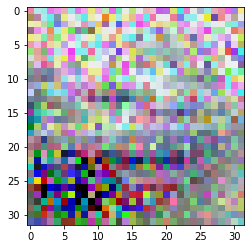

In [ ]:
noise_level = 0.5
test_with_noise = _inject_noise(data_test.data, noise_level)
__ = plt.imshow(test_with_noise[1].reshape(32, 32, 3))

In [ ]:
def _get_accuracy_values_at_noise_level(noise_level):
  test_with_noise = _inject_noise(data_test, noise_level)
  hidden_repr_layer_1_noisy = _get_kth_layer_repr(test_with_noise, 0)  # here we compute the representations
  hidden_repr_layer_2_noisy = _get_kth_layer_repr(hidden_repr_layer_1_noisy, 1)
  hidden_repr_layer_3_noisy = _get_kth_layer_repr(hidden_repr_layer_2_noisy, 2)
  predictions_first_hidden_noisy = perceptron_first_hidden(hidden_repr_layer_3_noisy)  # here we use the readout layer
  #predictions_ffnn_noisy = ffnn(test_with_noise.reshape((10000, 1024, 3)))
  accuracy_first_hidden,_ = _compute_accuracy(predictions_first_hidden_noisy, dataset_test.targets)
  #accuracy_ffnn = _compute_accuracy(predictions_ffnn_noisy, data_test.targets)
  return accuracy_first_hidden#, accuracy_ffnn

In [ ]:
_get_accuracy_values_at_noise_level(0.1)

0.35899999737739563

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_ffnn = []

  for noise_level in noise_levels:
    accuracy_first_hidden= _get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(accuracy_first_hidden)
    #accuracy_values_ffnn.append(accuracy_ffnn)

  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  #ax.plot(range(len(noise_levels)), accuracy_values_ffnn)

  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(np.arange(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden"])#, "FFNN"])

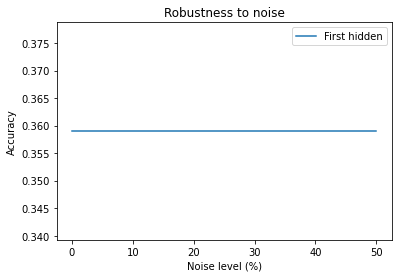

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
plot_noise_robustness_curves(noise_levels)

Apparently, the DBN has learnt a representation that allows the linear readout to resist the perturbation. A possible explanation is that the noise is not able to obscure the relevant features for the network. Since the accuracy is low, we first should try to increase the accuracy, improving the model.

## Conclusion 

Deep learning models have shown that they can learn features like humans, but as I said those models are very computational heavy. The architecture of an image classifier is different from the architecture of the DBN, which in principle is a generative model, whose feature can be also used to perform classification. But I think that increasing the number of neurons would lead also the DBN to learn a set of weights that can be used to reach a high level of accuracy in classification and can also learn features in a human-like way. In the laboratories, we saw a much simpler DBN architecture performing very well on classification, but it was trained on a much simpler dataset that is the MNIST dataset. There the images consist of handwritten digits, that are visually much simpler of a dog or a ship. In that case, the features to learn are much less, and the network has to learn a bunch of types of strokes and how to combine them. While in the CIFAR10 dataset the features to learn are more complex and also we have images that represent the same class of object from different perspectives, and that increase also the complexity. Most of the categories of the CIFAR10 contain objects that can be very different from the other objects of the same category, for example, dogs from different races or two different types of cars. Finally, the human-like clustering that the DBN achieves, indicates, at least in my opinion, that by increasing the complexity of the model we could achieve good results in terms of feature learned and classification, allowing also the generation of new images. 